In [318]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import random


In [319]:
# Chargement des données
file_path = "/Users/melusinecaillard/RSPL/data/cleaned_merged_seasons.csv"
data = pd.read_csv(file_path, low_memory=False)

In [320]:
# Ingénierie des caractéristiques
selected_features = ['name', 'position', 'team_x', 'value', 'goals_scored', 'assists', 'clean_sheets','total_points', 'yellow_cards', 'red_cards']  
X = data[selected_features]
y = data['total_points']

In [321]:
# Division des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [322]:
# Sélectionner uniquement les colonnes numériques
numeric_columns = X_train.select_dtypes(include=['number']).columns

# Normaliser uniquement les colonnes numériques
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[numeric_columns])
X_test_scaled = scaler.transform(X_test[numeric_columns])

In [323]:
# Création du modèle
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='linear'))

In [324]:
# Afficher le sommaire du modèle pour trouver le nom de la dernière couche convolutive
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 128)               1024      
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 9345 (36.50 KB)
Trainable params: 9345 (36.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [325]:
# Compilation du modèle
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

In [326]:
# Arrêt précoce pour éviter le surapprentissage
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [327]:
# Entraînement du modèle
history = model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping], verbose=1)

Epoch 1/100
1924/1924 [==============================] - 14s 6ms/step - loss: 0.6660 - mae: 0.3826 - val_loss: 0.0510 - val_mae: 0.1115
Epoch 2/100
1924/1924 [==============================] - 9s 5ms/step - loss: 0.3713 - mae: 0.2885 - val_loss: 0.0378 - val_mae: 0.0998
Epoch 3/100
1924/1924 [==============================] - 11s 6ms/step - loss: 0.3238 - mae: 0.2836 - val_loss: 0.0103 - val_mae: 0.0625
Epoch 4/100
1924/1924 [==============================] - 9s 5ms/step - loss: 0.3045 - mae: 0.2841 - val_loss: 0.0239 - val_mae: 0.0749
Epoch 5/100
1924/1924 [==============================] - 10s 5ms/step - loss: 0.2986 - mae: 0.2863 - val_loss: 0.0201 - val_mae: 0.0719
Epoch 6/100
1924/1924 [==============================] - 9s 5ms/step - loss: 0.2930 - mae: 0.2853 - val_loss: 0.0093 - val_mae: 0.0642
Epoch 7/100
1924/1924 [==============================] - 9s 5ms/step - loss: 0.2786 - mae: 0.2851 - val_loss: 0.0065 - val_mae: 0.0377
Epoch 8/100
1924/1924 [=============================

In [328]:
# Évaluation du modèle sur l'ensemble de test
y_pred = model.predict(X_test_scaled)

602/602 [==============================] - 2s 3ms/step


In [329]:
# Calcul des métriques d'évaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

In [330]:
print("Mean Squared Error:", mse)
print("R-squared:", r2)
print("Mean Absolute Error:", mae)

Mean Squared Error: 0.005291559691835079
R-squared: 0.9991642163003683
Mean Absolute Error: 0.06010723220616551


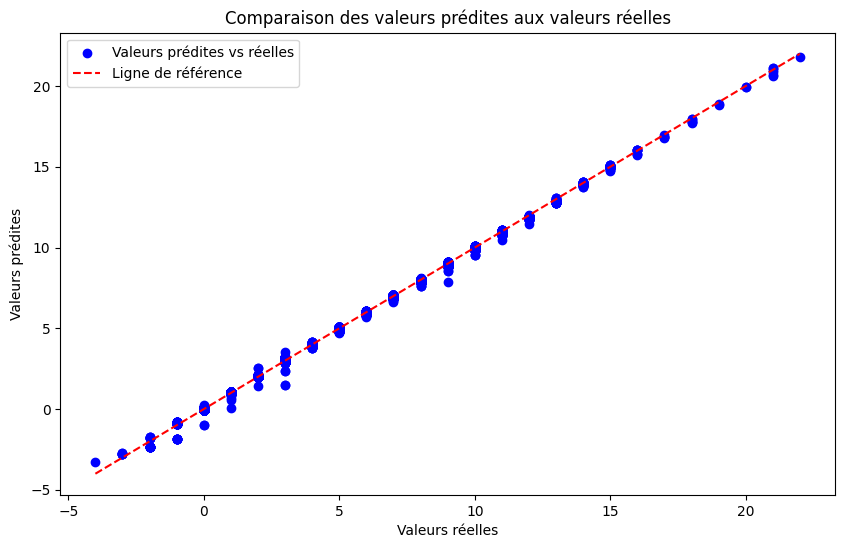

In [331]:
# Tracer les valeurs réelles par rapport aux valeurs prédites
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', label='Valeurs prédites vs réelles')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Ligne de référence')
plt.xlabel('Valeurs réelles')
plt.ylabel('Valeurs prédites')
plt.title('Comparaison des valeurs prédites aux valeurs réelles')
plt.legend()
plt.show()

In [332]:
# Calculer les résidus
residuals = y_test.values.flatten() - y_pred.flatten()

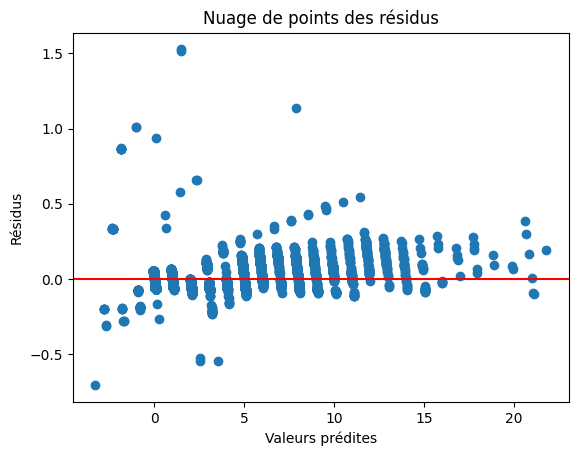

In [333]:
# Nuage de points entre les valeurs prédites et les résidus
plt.scatter(y_pred.flatten(), residuals)
plt.axhline(y=0, color='r', linestyle='-')
plt.title('Nuage de points des résidus')
plt.xlabel('Valeurs prédites')
plt.ylabel('Résidus')
plt.show()

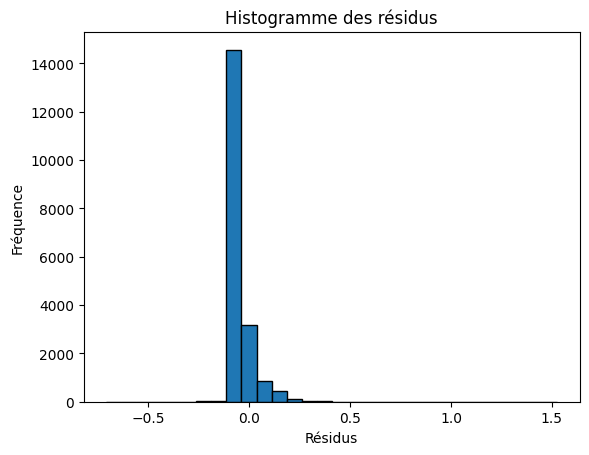

In [334]:
# Histogramme des résidus
plt.hist(residuals, bins=30, edgecolor='k')
plt.title('Histogramme des résidus')
plt.xlabel('Résidus')
plt.ylabel('Fréquence')
plt.show()

JOUEUR

In [335]:
def predict_player_performance(model, player_name, data):
    # Filtrer les données pour obtenir les caractéristiques du joueur spécifié
    player_data = data[data['name'] == player_name]
    
    # Sélectionner uniquement les caractéristiques utilisées lors de l'entraînement
    selected_features = [ 'value', 'goals_scored', 'assists', 'clean_sheets', 'total_points', 'yellow_cards', 'red_cards']
    player_data = player_data[selected_features]

    # Effectuer la prédiction
    predicted_performance = model.predict(player_data)
    
    # Calculer la moyenne des performances prédites
    average_performance = np.mean(predicted_performance)
    
    return average_performance
    


In [384]:
# Nom du joueur à prédire
player_name = 'Kyle Walker'

# Prédiction des performances du joueur
predicted_performance = predict_player_performance(model, player_name, data)

print("Performances prédites (total_points) pour le joueur: ",player_name, predicted_performance)


6/6 [==============================] - 0s 4ms/step
Performances prédites (total_points) pour le joueur:  Kyle Walker 7.187074


EQUIPE

In [337]:
import random

In [370]:
def select_random_players(data, position, num_players=100):
    # Sélectionne aléatoirement num_players joueurs pour une position donnée
    players = data[data['position'] == position]['name'].unique()
    return random.sample(list(players), min(num_players, len(players)))

def select_random_players_by_position(data):
    # Sélectionne aléatoirement 50 joueurs pour chaque position et les stocke dans des listes distinctes
    goalkeepers = select_random_players(data, 'GK')
    defenders = select_random_players(data, 'DEF')
    midfielders = select_random_players(data, 'MID')
    forwards = select_random_players(data, 'FWD')
    return goalkeepers, defenders, midfielders, forwards

# Appeler la fonction pour sélectionner les joueurs aléatoires par position
goalkeepers, defenders, midfielders, forwards = select_random_players_by_position(data)
preselected_player = goalkeepers + defenders + midfielders + forwards

In [371]:
print(goalkeepers)

['Loris Karius', 'Matt Macey', 'Joe Hart', 'Kristoffer Klaesson', 'Mark Gillespie', 'Daniel Bachmann', 'Roberto Jimenez Gago', 'Caoimhin Kelleher', 'Lukasz Fabianski', 'Michael McGovern', 'Remi Matthews', 'Aaron Ramsdale', 'Keylor Navas', 'Krisztián Hegyi', 'Kasper Schmeichel', 'Filip Marschall', 'Viljami Sinisalo', 'Michael Verrips', 'Darren Randolph', 'Kamil Miazek', 'Elia Caprile', 'Sam Waller', 'George Shelvey', 'Brice Samba', 'David Martin', 'Emiliano Martínez Romero', 'Alex Smithies', 'Norberto Murara Neto', 'Claudio Bravo', 'Paulo Gazzaniga', 'Simon Moore', 'Lee Grant', 'Brandon Austin', 'George Wickens', 'Paulo Gazzaniga Farias', 'Vicente Guaita', 'Marcus Bettinelli', 'Sergio Romero', 'Álvaro Fernández', 'Ørjan Nyland', 'Jed Steer', 'David Raya Martin', 'Ellery Balcombe', 'Alisson Ramses Becker', 'Zack Steffen', 'Arthur Okonkwo', 'Joseph Anang', 'Mark Travers', 'Jonas Lössl', 'Dean Henderson', 'Martin Dubravka', 'Bernd Leno', 'James Storer', 'Will Norris', 'Rúnar Alex Rúnarsson

In [372]:
def predict_performance_for_random_players(model, data, players_by_position):
    # Effectue les prédictions de performance pour les joueurs sélectionnés aléatoirement par position
    predicted_performances = {}
    for position, players in players_by_position.items():
        for player_name in players:
            predicted_performance = predict_player_performance(model, player_name, data)
            # Stocke la performance prédite dans un dictionnaire avec le nom du joueur comme clé
            predicted_performances[player_name] = predicted_performance
    return predicted_performances

# Créer un dictionnaire contenant les listes de joueurs par position
players_by_position = {
    'GK': goalkeepers,
    'DEF': defenders,
    'MID': midfielders,
    'FWD': forwards
}

# Appeler la fonction pour prédire les performances des joueurs par position
predicted_performances = predict_performance_for_random_players(model, data, players_by_position)


2/2 [==============================] - 1s 12ms/step


In [373]:
print(predicted_performances)

{'Loris Karius': 3.6754076, 'Matt Macey': 1.1612219, 'Joe Hart': 2.0334685, 'Kristoffer Klaesson': 1.2202414, 'Mark Gillespie': 1.159837, 'Daniel Bachmann': 2.0905006, 'Roberto Jimenez Gago': 1.1619177, 'Caoimhin Kelleher': 1.5760633, 'Lukasz Fabianski': 9.085084, 'Michael McGovern': 1.1586447, 'Remi Matthews': 1.1587058, 'Aaron Ramsdale': 7.3102694, 'Keylor Navas': 6.493956, 'Krisztián Hegyi': 1.1585603, 'Kasper Schmeichel': 6.983703, 'Filip Marschall': 1.1587561, 'Viljami Sinisalo': 1.1587561, 'Michael Verrips': 1.1587561, 'Darren Randolph': 2.0946727, 'Kamil Miazek': 1.1587561, 'Elia Caprile': 1.1587561, 'Sam Waller': 1.1587561, 'George Shelvey': 1.1587561, 'Brice Samba': 1.1619177, 'David Martin': 1.158688, 'Emiliano Martínez Romero': 9.287205, 'Alex Smithies': 1.1586516, 'Norberto Murara Neto': 6.907329, 'Claudio Bravo': 2.8160527, 'Paulo Gazzaniga': 1.3642299, 'Simon Moore': 1.1608572, 'Lee Grant': 3.6532474, 'Brandon Austin': 1.1586616, 'George Wickens': 1.1587561, 'Paulo Gazzan

In [374]:
def recommend_team_from_predicted_performances(predicted_performances, data, budget=1000, max_players_per_team=3):
    team = []
    remaining_budget = budget
    positions_quota = {'GK': 2, 'DEF': 5, 'MID': 5, 'FWD': 3}
    positions_count = {'GK': 0, 'DEF': 0, 'MID': 0, 'FWD': 0}

    # Tri des joueurs prédits par performances décroissantes
    sorted_players = sorted(predicted_performances.items(), key=lambda x: x[1], reverse=True)

    # Sélection des joueurs pour l'équipe en respectant les contraintes
    for player_name, predicted_performance in sorted_players:
        player_data = data[data['name'] == player_name].iloc[0]
        player_cost = player_data['value']
        player_position = player_data['position']
        player_team = player_data['team_x']

        # Vérification des contraintes de budget et de nombre maximum de joueurs par équipe
        if len(team) < 15 and player_cost <= remaining_budget and team.count(player_team) < max_players_per_team:
            if positions_count[player_position] < positions_quota[player_position]:
                team.append((player_name, predicted_performance))
                remaining_budget -= player_cost
                positions_count[player_position] += 1

    return team

In [375]:
# Afficher la composition de l'équipe recommandée
print("Composition d'équipe recommandée:")
print(recommend_team_from_predicted_performances(predicted_performances,data,budget=1000, max_players_per_team=3))


Composition d'équipe recommandée:
[('Erling Haaland', 16.540115), ('Bruno Miguel Borges Fernandes', 11.457617), ('David De Gea Quintana', 10.829479), ('Alisson Ramses Becker', 10.573772), ('Bruno Borges Fernandes', 10.408141), ('Ivan Toney', 10.241132), ('Cody Gakpo', 9.668974), ('James Maddison', 9.51857), ('Kaoru Mitoma', 9.316569), ('Romelu Lukaku', 9.279969), ('Andrew Robertson', 8.692561), ('Trent Alexander-Arnold', 8.22334), ('Antonio Rüdiger', 8.159134), ('Rico Henry', 7.671472)]


In [377]:
def recommend_team_from_predicted_performances(predicted_performances, data, budget=1000, max_players_per_team=3):
    team = []
    remaining_budget = budget
    positions_quota = {'GK': 2, 'DEF': 5, 'MID': 5, 'FWD': 3}
    positions_count = {'GK': 0, 'DEF': 0, 'MID': 0, 'FWD': 0}

    # Tri des joueurs prédits par performances décroissantes
    sorted_players = sorted(predicted_performances.items(), key=lambda x: x[1], reverse=True)

    # Sélection des joueurs pour l'équipe en respectant les contraintes
    for player_name, predicted_performance in sorted_players:
        player_data = data[data['name'] == player_name].iloc[0]
        player_cost = player_data['value']
        player_position = player_data['position']
        player_team = player_data['team_x']

        # Vérification des contraintes de budget et de nombre maximum de joueurs par équipe
        if len(team) < 15 and player_cost <= remaining_budget and team.count(player_team) < max_players_per_team:
            if positions_count[player_position] < positions_quota[player_position]:
                team.append({
                    'name': player_name,
                    'position': player_position,
                    'team': player_team,
                    'cost': player_cost,
                    'predicted_performance': predicted_performance
                })
                remaining_budget -= player_cost
                positions_count[player_position] += 1

    return team

# Afficher la composition de l'équipe recommandée
print("Composition d'équipe recommandée:")
recommended_team = recommend_team_from_predicted_performances(predicted_performances, data, budget=1000, max_players_per_team=3)
for player in recommended_team:
    print("Joueur:", player['name'])
    print("Poste:", player['position'])
    print("Équipe:", player['team'])
    print("Prix:", player['cost'], 'k£')
    print("Score prédit:", player['predicted_performance'])
    print()


Composition d'équipe recommandée:
Joueur: Erling Haaland
Poste: FWD
Équipe: Man City
Prix: 115 k£
Score prédit: 16.540115

Joueur: Bruno Miguel Borges Fernandes
Poste: MID
Équipe: Man Utd
Prix: 105 k£
Score prédit: 11.457617

Joueur: David De Gea Quintana
Poste: GK
Équipe: Man Utd
Prix: 50 k£
Score prédit: 10.829479

Joueur: Alisson Ramses Becker
Poste: GK
Équipe: Liverpool
Prix: 60 k£
Score prédit: 10.573772

Joueur: Bruno Borges Fernandes
Poste: MID
Équipe: Man Utd
Prix: 100 k£
Score prédit: 10.408141

Joueur: Ivan Toney
Poste: FWD
Équipe: Brentford
Prix: 65 k£
Score prédit: 10.241132

Joueur: Cody Gakpo
Poste: MID
Équipe: Liverpool
Prix: 80 k£
Score prédit: 9.668974

Joueur: James Maddison
Poste: MID
Équipe: Leicester
Prix: 70 k£
Score prédit: 9.51857

Joueur: Kaoru Mitoma
Poste: MID
Équipe: Brighton
Prix: 50 k£
Score prédit: 9.316569

Joueur: Romelu Lukaku
Poste: FWD
Équipe: nan
Prix: 90 k£
Score prédit: 9.279969

Joueur: Andrew Robertson
Poste: DEF
Équipe: nan
Prix: 45 k£
Score pr

In [385]:
#meme code que la cellule d'avant
def recommend_team_from_predicted_performances(predicted_performances, data, budget=1000, max_players_per_team=3):
    team = []
    remaining_budget = budget
    total_cost = 0
    total_predicted_performance = 0
    positions_quota = {'GK': 2, 'DEF': 5, 'MID': 5, 'FWD': 3}
    positions_count = {'GK': 0, 'DEF': 0, 'MID': 0, 'FWD': 0}

    # Tri des joueurs prédits par performances décroissantes
    sorted_players = sorted(predicted_performances.items(), key=lambda x: x[1], reverse=True)

    # Sélection des joueurs pour l'équipe en respectant les contraintes
    for player_name, predicted_performance in sorted_players:
        player_data = data[data['name'] == player_name].iloc[0]
        player_cost = player_data['value']
        player_position = player_data['position']
        player_team = player_data['team_x']

        # Vérification des contraintes de budget et de nombre maximum de joueurs par équipe
        if len(team) < 15 and player_cost <= remaining_budget and team.count(player_team) < max_players_per_team:
            if positions_count[player_position] < positions_quota[player_position]:
                team.append({
                    'name': player_name,
                    'position': player_position,
                    'team': player_team,
                    'cost': player_cost,
                    'predicted_performance': predicted_performance
                })
                remaining_budget -= player_cost
                total_cost += player_cost
                total_predicted_performance += predicted_performance
                positions_count[player_position] += 1

    return team, total_cost, total_predicted_performance, len(team)

# Afficher la composition de l'équipe recommandée
print("Composition d'équipe recommandée:")
recommended_team, total_cost, total_predicted_performance, num_players = recommend_team_from_predicted_performances(predicted_performances, data, budget=1000, max_players_per_team=3)
for player in recommended_team:
    print("Joueur:", player['name'])
    print("Poste:", player['position'])
    print("Équipe:", player['team'])
    print("Prix:", player['cost'], 'k£')
    print("Score prédit:", player['predicted_performance'])
    print()

print("Coût total de l'équipe:", total_cost, 'k£')
print("Score total de l'équipe:", total_predicted_performance)
print("Nombre de joueurs dans l'équipe:", num_players)


Composition d'équipe recommandée:
Joueur: Erling Haaland
Poste: FWD
Équipe: Man City
Prix: 115 k£
Score prédit: 16.540115

Joueur: Bruno Miguel Borges Fernandes
Poste: MID
Équipe: Man Utd
Prix: 105 k£
Score prédit: 11.457617

Joueur: David De Gea Quintana
Poste: GK
Équipe: Man Utd
Prix: 50 k£
Score prédit: 10.829479

Joueur: Alisson Ramses Becker
Poste: GK
Équipe: Liverpool
Prix: 60 k£
Score prédit: 10.573772

Joueur: Bruno Borges Fernandes
Poste: MID
Équipe: Man Utd
Prix: 100 k£
Score prédit: 10.408141

Joueur: Ivan Toney
Poste: FWD
Équipe: Brentford
Prix: 65 k£
Score prédit: 10.241132

Joueur: Cody Gakpo
Poste: MID
Équipe: Liverpool
Prix: 80 k£
Score prédit: 9.668974

Joueur: James Maddison
Poste: MID
Équipe: Leicester
Prix: 70 k£
Score prédit: 9.51857

Joueur: Kaoru Mitoma
Poste: MID
Équipe: Brighton
Prix: 50 k£
Score prédit: 9.316569

Joueur: Romelu Lukaku
Poste: FWD
Équipe: nan
Prix: 90 k£
Score prédit: 9.279969

Joueur: Andrew Robertson
Poste: DEF
Équipe: nan
Prix: 45 k£
Score pr

In [388]:
def recommend_team_from_predicted_performances(predicted_performances, data, budget=1000, max_players_per_team=3):
    team = []
    remaining_budget = budget
    positions_quota = {'GK': 2, 'DEF': 5, 'MID': 5, 'FWD': 3}
    positions_count = {'GK': 0, 'DEF': 0, 'MID': 0, 'FWD': 0}

    # Tri des joueurs prédits par performances décroissantes en fonction de la performance divisée par le coût
    sorted_players = sorted(predicted_performances.items(), key=lambda x: x[1] / data[data['name'] == x[0]]['value'].iloc[0], reverse=True)

    # Sélection des joueurs pour l'équipe en respectant les contraintes
    for player_name, predicted_performance in sorted_players:
        player_data = data[data['name'] == player_name].iloc[0]
        player_cost = player_data['value']
        player_position = player_data['position']
        player_team = player_data['team_x']

        # Vérification des contraintes de budget et de nombre maximum de joueurs par équipe
        if len(team) < 15 and player_cost <= remaining_budget and team.count(player_team) < max_players_per_team:
            if positions_count[player_position] < positions_quota[player_position]:
                team.append({
                    'name': player_name,
                    'position': player_position,
                    'team': player_team,
                    'cost': player_cost,
                    'predicted_performance': predicted_performance
                })
                remaining_budget -= player_cost
                positions_count[player_position] += 1

    return team

# Afficher la composition de l'équipe recommandée
print("Composition d'équipe recommandée:")
recommended_team = recommend_team_from_predicted_performances(predicted_performances, data, budget=1000, max_players_per_team=3)
for player in recommended_team:
    print("Joueur:", player['name'])
    print("Poste:", player['position'])
    print("Équipe:", player['team'])
    print("Prix:", player['cost'], 'k£')
    print("Score prédit:", player['predicted_performance'])
    print()
print(len(recommended_team))

Composition d'équipe recommandée:
Joueur: Emiliano Martínez
Poste: GK
Équipe: Arsenal
Prix: 45 k£
Score prédit: 10.392884

Joueur: David De Gea Quintana
Poste: GK
Équipe: Man Utd
Prix: 50 k£
Score prédit: 10.829479

Joueur: Andrew Robertson
Poste: DEF
Équipe: nan
Prix: 45 k£
Score prédit: 8.692561

Joueur: Andreas Hoelgebaum Pereira
Poste: MID
Équipe: Fulham
Prix: 45 k£
Score prédit: 8.634114

Joueur: Kaoru Mitoma
Poste: MID
Équipe: Brighton
Prix: 50 k£
Score prédit: 9.316569

Joueur: Trent Alexander-Arnold
Poste: DEF
Équipe: nan
Prix: 45 k£
Score prédit: 8.22334

Joueur: Daniel Jebbison
Poste: FWD
Équipe: Sheffield Utd
Prix: 45 k£
Score prédit: 8.058805

Joueur: Rico Henry
Poste: DEF
Équipe: Brentford
Prix: 45 k£
Score prédit: 7.671472

Joueur: Lewis Dunk
Poste: DEF
Équipe: nan
Prix: 45 k£
Score prédit: 7.6349463

Joueur: Ben White
Poste: DEF
Équipe: Brighton
Prix: 45 k£
Score prédit: 7.4363604

Joueur: Bryan Mbeumo
Poste: MID
Équipe: Brentford
Prix: 55 k£
Score prédit: 9.03415

Joueu

In [379]:
def recommend_team_from_predicted_performances(predicted_performances, data, budget=100, max_players_per_team=3):
    team = []
    remaining_budget = budget
    positions_quota = {'GK': 2, 'DEF': 5, 'MID': 5, 'FWD': 3}
    positions_count = {'GK': 0, 'DEF': 0, 'MID': 0, 'FWD': 0}
    num_players = 15

    # Tri des joueurs prédits par performances décroissantes en fonction de la performance divisée par le coût
    sorted_players = sorted(predicted_performances.items(), key=lambda x: x[1] / data[data['name'] == x[0]]['value'].iloc[0], reverse=True)

    # Calcul de la somme des coûts des 15 meilleurs joueurs
    total_cost_top_players = sum([data[data['name'] == player_name]['value'].iloc[0] for player_name, _ in sorted_players[:num_players]])

    # Répartition équitable du budget entre les 15 joueurs
    budget_per_player = budget / num_players

    # Sélection des joueurs pour l'équipe en respectant les contraintes et le budget alloué
    for player_name, predicted_performance in sorted_players:
        player_data = data[data['name'] == player_name].iloc[0]
        player_cost = player_data['value']
        player_position = player_data['position']
        player_team = player_data['team_x']

        # Vérification des contraintes de nombre de joueurs par poste et de nombre maximum de joueurs par équipe
        if len(team) < num_players and player_cost <= budget_per_player and team.count(player_team) < max_players_per_team:
            if positions_count[player_position] < positions_quota[player_position]:
                team.append({
                    'name': player_name,
                    'position': player_position,
                    'team': player_team,
                    'cost': player_cost,
                    'predicted_performance': predicted_performance
                })
                positions_count[player_position] += 1

    return team

# Afficher la composition de l'équipe recommandée
print("Composition d'équipe recommandée:")
recommended_team = recommend_team_from_predicted_performances(predicted_performances, data, budget=1000, max_players_per_team=3)
for player in recommended_team:
    print("Joueur:", player['name'])
    print("Poste:", player['position'])
    print("Équipe:", player['team'])
    print("Prix:", player['cost'], 'k£')
    print("Score prédit:", player['predicted_performance'])
    print()


Composition d'équipe recommandée:
Joueur: Emiliano Martínez
Poste: GK
Équipe: Arsenal
Prix: 45 k£
Score prédit: 10.392884

Joueur: David De Gea Quintana
Poste: GK
Équipe: Man Utd
Prix: 50 k£
Score prédit: 10.829479

Joueur: Andrew Robertson
Poste: DEF
Équipe: nan
Prix: 45 k£
Score prédit: 8.692561

Joueur: Andreas Hoelgebaum Pereira
Poste: MID
Équipe: Fulham
Prix: 45 k£
Score prédit: 8.634114

Joueur: Kaoru Mitoma
Poste: MID
Équipe: Brighton
Prix: 50 k£
Score prédit: 9.316569

Joueur: Trent Alexander-Arnold
Poste: DEF
Équipe: nan
Prix: 45 k£
Score prédit: 8.22334

Joueur: Daniel Jebbison
Poste: FWD
Équipe: Sheffield Utd
Prix: 45 k£
Score prédit: 8.058805

Joueur: Rico Henry
Poste: DEF
Équipe: Brentford
Prix: 45 k£
Score prédit: 7.671472

Joueur: Lewis Dunk
Poste: DEF
Équipe: nan
Prix: 45 k£
Score prédit: 7.6349463

Joueur: Ben White
Poste: DEF
Équipe: Brighton
Prix: 45 k£
Score prédit: 7.4363604

Joueur: Bryan Mbeumo
Poste: MID
Équipe: Brentford
Prix: 55 k£
Score prédit: 9.03415

Joueu